# Colab librerias

In [1]:
# --- Detectar si estamos en Google Colab ---
def running_in_colab() -> bool:
    try:
        import google.colab  # solo existe en Colab
        return True
    except ImportError:
        return False

# Instalar dependencias si estamos en Colab
if running_in_colab():
    # pyvista[jupyter] es suficiente; backend html funciona estable
    %pip install -q "pyvista[jupyter]"
    pv_backend = "html"
else:
    pv_backend = "trame"

print("Usando backend:", pv_backend)


Usando backend: trame


# Importación de librerías y creación de variables

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

# Use the Trame backend for interactive inline plots
pv.set_jupyter_backend(pv_backend)

n = 1 # Number of stacks of Miller indexes in each direction
a = 1.0 # Lattice constant
c = 1.0 # Lattice constant in z direction
lambda_X = 1.54 # X-ray wavelength in Angstroms

f_H = 1 # Atomic form factor for Hydrogen (approximation)

hex_angle = 2 * np.pi / 3 # radians

lattice_vectors = np.array([
    [a, 0, 0],
    [a * np.cos(hex_angle), a * np.sin(hex_angle), 0],
    [0, 0, c]
], dtype=float) # Lattice vectors

# Bases atómicas en coordenadas fraccionales
base_fractional = np.array([
    [1/2, 1/2, 0],
    [0, 1/2, 1/3],
    [1/2, 0, 2/3],
    [1/2, 1/2, 1] # Esta solo es para visualizar la tapa superior de la celda
], dtype=float)  # Atomic basis in fractional coordinates

base = base_fractional @ lattice_vectors  # Coordenadas de los átomos en la celda unitaria

# Define Miller index to work with
Miller_indexes = np.stack(np.mgrid[0:n+2, 0:n+2, 0:n+2], axis=-1).astype(float)  # (n+2, n+2, n+2, 3) Miller indices grid
Miller_indexes = Miller_indexes.reshape(-1,3)[1:]  # Convertir a un array (n+2^3, 3)

# Construcción de malla
I, J, K = np.mgrid[-n:n+1, -n-1:n+1, 0:1]  # (2n+1, 2n+1, 2n+1) grid

# Combinación lineal increible
lattice_vec = I[..., None] * lattice_vectors[0] + J[..., None] * lattice_vectors[1] + K[..., None] * lattice_vectors[2]
lattice_vec = lattice_vec.reshape(-1,3)[1:] # Al poner -1, numpy infiere la cantidad de puntos

# Ordenamiento y eliminacion de puntos innecesarios
mag = np.linalg.norm(lattice_vec, axis=1)
order = np.argsort(mag)
lattice_vec = lattice_vec[order][:7] # Tomar los primeros 7 puntos más cercanos al origen

lattice = base[:, None, :] + lattice_vec[None, :, :]  # (4, 7, 3)
lattice = lattice.reshape(-1, 3)  # (28, 3)

In [3]:
def puntos_grafica(base, color, label, lattice_vectors):
    lengths = np.linalg.norm(lattice_vectors, axis=1)
    r = np.min(lengths) / 10  # Radio de las esferas (átomos)
    for i in range(np.size(base, 0)):  # Iterar sobre cada átomo en la base
        # Crear una esfera pequeña para representar un punto
        punto = pv.Sphere(radius=r, center=base[i])  # Centro en la posición del átomo
        # Añadir la esfera con un color específico y un nombre para la leyenda
        plotter.add_mesh(
            punto,
            color=color,
            label=label
        )

# Crear el plotter
plotter = pv.Plotter(notebook=True)

puntos_grafica(lattice, "green", "Nan", lattice_vectors)

# Añadir la leyenda
plotter.add_legend()

# Mostrar
plotter.show(jupyter_backend=pv_backend)

Widget(value='<iframe src="http://localhost:3521/index.html?ui=P_0x21326b712b0_0&reconnect=auto" class="pyvist…

# Celda reciproca

In [4]:
# Calculate reciprocal lattice vectors
reciprocal_vectors = np.zeros((3, 3), dtype=float) # To store reciprocal lattice vectors
for i in range(3):
    reciprocal_vectors[i] = 2 * np.pi * np.cross(lattice_vectors[np.mod(i+1, 3)], lattice_vectors[np.mod(i+2, 3)])  / np.linalg.det(lattice_vectors)

print("Reciprocal Lattice Vectors:")
print(reciprocal_vectors)

Reciprocal Lattice Vectors:
[[ 6.28318531  3.62759873 -0.        ]
 [ 0.          7.25519746  0.        ]
 [ 0.         -0.          6.28318531]]


# Calculo de factor de estructura e intensidad

In [5]:
# Calculate reciprocal lattice vector
G = Miller_indexes @ reciprocal_vectors.T  # (n^3, 3) Reciprocal lattice vectors
d_G = np.linalg.norm(G, axis=1)  # (n^3,) Magnitudes of G vectors

# Calculate phase factors
phase_factor = np.exp(1j * (G @ base_fractional[:3].T))  # ( n^3, 2 ) Phase factors for Oxygen atoms

# Calculate structure factors
structure_factor = f_H * np.sum(phase_factor, axis=1)  # ( n^3, ) Structure factors for Oxygen

intensity = np.abs(structure_factor)**2  # ( n^3, ) Intensities
intensity /= np.max(intensity)  # Normalize intensities

# Calculate Bragg angles
theta = np.arcsin(lambda_X / (2 * d_G))  # ( n^3, ) Bragg angles in radians
theta = np.degrees(theta)  # Convert to degrees

# Eliminacion de repetidos y ordenamiento

In [6]:
order = np.argsort(theta)
# Sort by theta
theta = theta[order]
intensity = intensity[order]
Miller_indexes = Miller_indexes[order]

# Find unique rows and their counts
theta, idx, counts = np.unique(theta, axis=0, return_index=True, return_counts=True)
intensity = intensity[idx]
Miller_indexes_unique = Miller_indexes[idx]

theta_times2 = 2 * theta

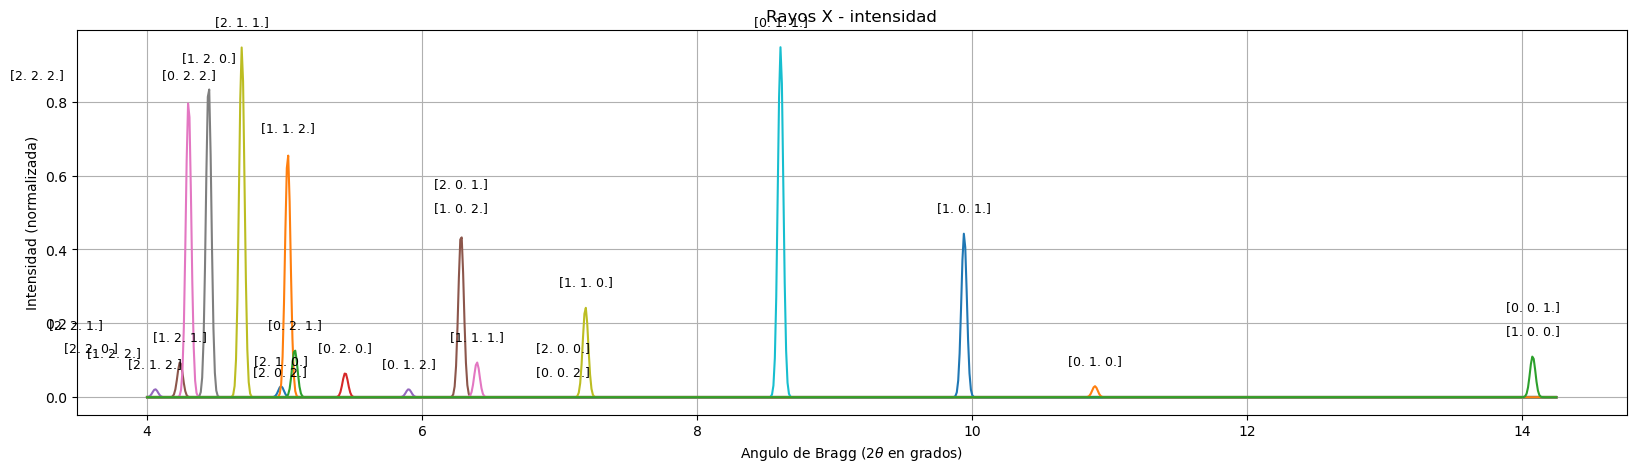

In [7]:
fig, ax = plt.subplots(figsize=(20, 5))

##### Esto me lo dijo chatgpt, no tenia la mas remota idea de como hacerlo
# Dominio continuo para la gráfica
x = np.linspace(4, 14.25, 1000)

# Ancho de las campanas (muy pequeño)
sigma = 0.02

# Graficar cada delta como una gaussiana angosta
for xi, ai in zip(theta_times2, intensity):
    y = ai * np.exp(- (x - xi)**2 / (2*sigma**2))
    plt.plot(x, y)
##### Hasta aquí

# Añadir las etiquetas encima de cada punto
for i in range(len(theta)):
    for j in range(counts[i]):
        plt.text(theta_times2[i], intensity[i] + 0.05 + 0.065*j,  # un poquito por encima
                f"{Miller_indexes[idx[i] + j]}",    # convierte (1,1,1) a texto
                ha='center', va='bottom',
                fontsize=9)

# Etiquetas y títulos
plt.xlabel(r"Angulo de Bragg ($2\theta$ en grados)")
plt.ylabel("Intensidad (normalizada)")
plt.title("Rayos X - intensidad")
plt.grid(True)

plt.show()